# TUDatasets Graph Classification Benchmarks for ISP-GNN Evaluation

This notebook demonstrates how to load and process TUDataset graph classification benchmarks into a standardized schema format for evaluating graph neural networks.

**What this artifact does:**
- Loads raw graph data (MUTAG dataset: mutagenic compound classification)
- Converts each graph into a standardized example with `input` (JSON graph structure), `output` (class label), and metadata fields
- Groups graphs by dataset with stratified 10-fold CV fold assignments
- Includes published baseline accuracies from GIN (ICLR 2019), GSN (TPAMI 2022)

**Demo data:** 20 diverse MUTAG graphs (10 per class, varied sizes 10–25 nodes)

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# networkx — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0', 'networkx==3.6.1')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import os
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-1a90b0-interference-based-structural-probing-br/main/dataset_iter1_tudatasets_grap/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded data with {len(data['datasets'])} dataset(s)")
print(f"Metadata keys: {list(data['metadata'].keys())}")

Loaded data with 1 dataset(s)
Metadata keys: ['description', 'source', 'source_paper', 'cv_folds', 'cv_seed', 'evaluation_protocol', 'total_graphs', 'dataset_statistics', 'baselines']


## Configuration

Control how many examples per dataset to process. Set to `0` for no limit (process all).

In [5]:
# ── Tunable parameters ──
# MAX_EXAMPLES: max examples per dataset (0 = no limit)
# Original value: 0 (all examples)
MAX_EXAMPLES = 0  # Process all examples in mini demo data

## Extract Graphs and Metadata

Parse the loaded data to access individual graph examples, dataset metadata, and baseline results.

In [6]:
t0 = time.time()

# Extract graphs from all datasets in the loaded data
graphs = []
for ds in data["datasets"]:
    ds_name = ds["dataset"]
    for ex in ds["examples"]:
        # Parse the input JSON string back to a dict
        graph_struct = json.loads(ex["input"])
        graphs.append({
            "dataset": ds_name,
            "edge_list": graph_struct["edge_list"],
            "node_features": graph_struct["node_features"],
            "num_nodes": graph_struct["num_nodes"],
            "num_edges": graph_struct["num_edges"],
            "label": int(ex["output"]),
            "fold": ex["metadata_fold"],
            "graph_id": ex["metadata_graph_id"],
        })

metadata = data["metadata"]
baselines = metadata["baselines"]

print(f"Loaded {len(graphs)} graphs in {time.time() - t0:.2f}s")

Loaded 20 graphs in 0.00s


## Group Graphs by Dataset

Organize the extracted graphs by their dataset name (following the original script's grouping logic).

In [7]:
# Group graphs by dataset
dataset_names = ["MUTAG", "PROTEINS", "IMDB-BINARY", "PTC_MR"]
graphs_by_ds = {ds: [] for ds in dataset_names}
for g in graphs:
    ds = g["dataset"]
    if ds in graphs_by_ds:
        graphs_by_ds[ds].append(g)

for ds_name, ds_graphs in graphs_by_ds.items():
    if ds_graphs:
        print(f"  {ds_name}: {len(ds_graphs)} graphs")

  MUTAG: 20 graphs


## Convert to Schema Format

Transform each graph into the `exp_sel_data_out` schema: `input` (JSON string of graph structure), `output` (class label string), and `metadata_*` fields for fold assignment, graph properties, and task info.

In [8]:
# Build output in schema format
output_datasets = []

for ds_name in dataset_names:
    ds_graphs = graphs_by_ds[ds_name]
    if not ds_graphs:
        continue

    # Get dataset statistics from metadata
    ds_stats = metadata["dataset_statistics"].get(ds_name, {})

    # Apply limit if set
    if MAX_EXAMPLES > 0:
        ds_graphs = ds_graphs[:MAX_EXAMPLES]

    examples = []
    for g in ds_graphs:
        # Build input: JSON string of graph structure
        graph_input = {
            "edge_list": g["edge_list"],
            "node_features": g["node_features"],
            "num_nodes": g["num_nodes"],
            "num_edges": g["num_edges"],
        }
        input_str = json.dumps(graph_input, separators=(",", ":"))

        # Build output: class label as string
        output_str = str(g["label"])

        # Build metadata fields (flat, prefixed with metadata_)
        example = {
            "input": input_str,
            "output": output_str,
            "metadata_fold": g["fold"],
            "metadata_graph_id": g["graph_id"],
            "metadata_task_type": "classification",
            "metadata_n_classes": 2,
            "metadata_num_nodes": g["num_nodes"],
            "metadata_num_edges": g["num_edges"],
            "metadata_feature_dim": ds_stats.get("feature_dim", 0),
        }

        examples.append(example)

    output_datasets.append({
        "dataset": ds_name,
        "examples": examples,
    })

    print(f"  {ds_name}: {len(examples)} examples")

  MUTAG: 20 examples


## Build Final Output

Assemble the complete output with top-level metadata (source, CV protocol, dataset statistics, baselines) and the converted dataset examples.

In [9]:
# Build final output with top-level metadata
final_output = {
    "metadata": {
        "description": metadata["description"],
        "source": metadata["source"],
        "source_paper": metadata["source_paper"],
        "cv_folds": metadata["cv_folds"],
        "cv_seed": metadata["cv_seed"],
        "evaluation_protocol": metadata["evaluation_protocol"],
        "total_graphs": sum(len(d["examples"]) for d in output_datasets),
        "dataset_statistics": metadata["dataset_statistics"],
        "baselines": baselines,
    },
    "datasets": output_datasets,
}

total_examples = sum(len(d["examples"]) for d in output_datasets)
elapsed = time.time() - t0

print(f"\nDone in {elapsed:.2f}s")
print(f"Total examples: {total_examples}")
print(f"Datasets: {len(output_datasets)}")
print(f"\nSample example keys: {list(output_datasets[0]['examples'][0].keys())}")


Done in 0.06s
Total examples: 20
Datasets: 1

Sample example keys: ['input', 'output', 'metadata_fold', 'metadata_graph_id', 'metadata_task_type', 'metadata_n_classes', 'metadata_num_nodes', 'metadata_num_edges', 'metadata_feature_dim']


## Visualization

**Top:** Dataset statistics summary and class distribution.
**Middle:** Graph size distribution (nodes vs edges) colored by class label.
**Bottom:** Baseline model accuracy comparison across datasets with published results from GIN, GSN, and other GNN architectures.

Dataset         Graphs  Avg Nodes  Avg Edges  Feat Dim
-----------------------------------------------------------------
MUTAG              188       17.9       19.8         7
PROTEINS          1113       39.1       72.8         4
IMDB-BINARY       1000       19.8       96.5         1
PTC_MR             344       14.3       14.7        18


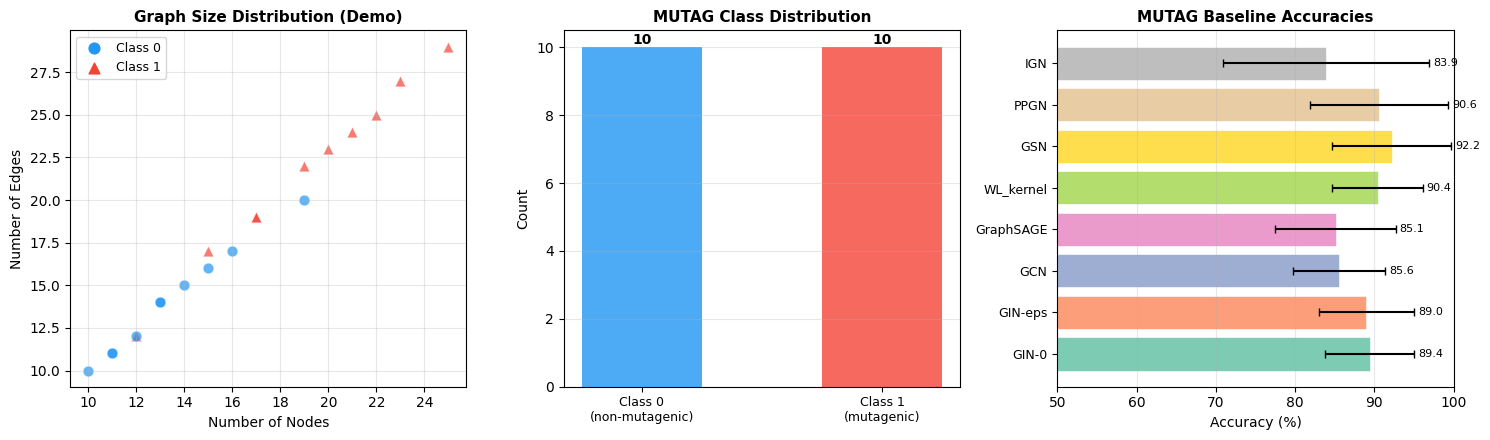


Saved: graph_analysis.png


In [10]:
# ── 1. Dataset statistics table ──
print("=" * 65)
print(f"{'Dataset':<14} {'Graphs':>7} {'Avg Nodes':>10} {'Avg Edges':>10} {'Feat Dim':>9}")
print("-" * 65)
for ds_name, ds_stats in metadata["dataset_statistics"].items():
    print(f"{ds_name:<14} {ds_stats['num_graphs']:>7} {ds_stats['avg_nodes']:>10.1f} "
          f"{ds_stats['avg_edges']:>10.1f} {ds_stats['feature_dim']:>9}")
print("=" * 65)

# ── 2. Scatter plot: nodes vs edges by class label ──
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Panel 1: Node vs Edge scatter for demo graphs
ax = axes[0]
for ds in output_datasets:
    for ex in ds["examples"]:
        color = "#2196F3" if ex["output"] == "0" else "#F44336"
        marker = "o" if ex["output"] == "0" else "^"
        ax.scatter(ex["metadata_num_nodes"], ex["metadata_num_edges"],
                   c=color, marker=marker, s=60, alpha=0.7, edgecolors="white", linewidth=0.5)

# Legend
ax.scatter([], [], c="#2196F3", marker="o", s=60, label="Class 0")
ax.scatter([], [], c="#F44336", marker="^", s=60, label="Class 1")
ax.legend(fontsize=9)
ax.set_xlabel("Number of Nodes", fontsize=10)
ax.set_ylabel("Number of Edges", fontsize=10)
ax.set_title("Graph Size Distribution (Demo)", fontsize=11, fontweight="bold")
ax.grid(True, alpha=0.3)

# Panel 2: Class distribution bar chart for demo data
ax = axes[1]
for ds in output_datasets:
    labels = [ex["output"] for ex in ds["examples"]]
    class_0 = labels.count("0")
    class_1 = labels.count("1")
    x = np.arange(2)
    bars = ax.bar(x, [class_0, class_1], color=["#2196F3", "#F44336"], alpha=0.8, width=0.5)
    ax.bar_label(bars, fontsize=10, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(["Class 0\n(non-mutagenic)", "Class 1\n(mutagenic)"], fontsize=9)
    ax.set_title(f"{ds['dataset']} Class Distribution", fontsize=11, fontweight="bold")
    ax.set_ylabel("Count", fontsize=10)
    ax.grid(True, alpha=0.3, axis="y")

# Panel 3: Baseline accuracy comparison
ax = axes[2]
baseline_results = baselines["results"]
# Use MUTAG baselines (the demo dataset)
if "MUTAG" in baseline_results:
    mutag_baselines = baseline_results["MUTAG"]
    models = list(mutag_baselines.keys())
    means = [mutag_baselines[m]["mean"] for m in models]
    stds = [mutag_baselines[m]["std"] for m in models]

    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    bars = ax.barh(range(len(models)), means, xerr=stds, color=colors,
                   alpha=0.85, capsize=3, edgecolor="white", linewidth=0.5)

    ax.set_yticks(range(len(models)))
    ax.set_yticklabels(models, fontsize=9)
    ax.set_xlabel("Accuracy (%)", fontsize=10)
    ax.set_title("MUTAG Baseline Accuracies", fontsize=11, fontweight="bold")
    ax.set_xlim(50, 100)
    ax.grid(True, alpha=0.3, axis="x")

    # Add value labels
    for i, (m, s) in enumerate(zip(means, stds)):
        ax.text(m + s + 0.5, i, f"{m:.1f}", va="center", fontsize=8)

plt.tight_layout()
plt.savefig("graph_analysis.png", dpi=120, bbox_inches="tight")
plt.show()
print("\nSaved: graph_analysis.png")

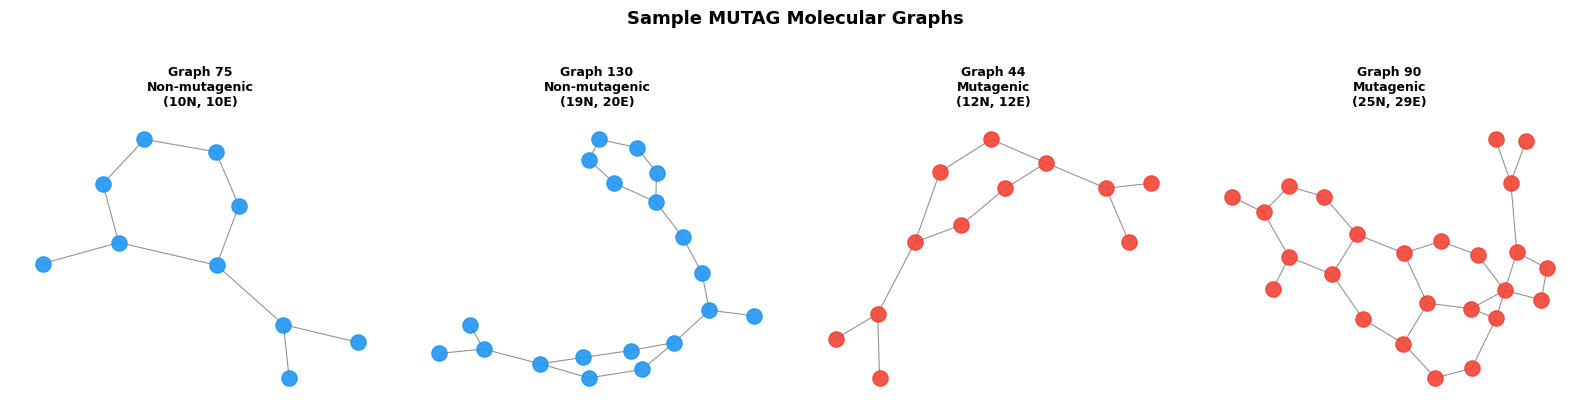

Saved: sample_graphs.png


In [11]:
# ── 3. Visualize sample graph structures ──
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Pick 4 sample graphs: 2 from each class, varied sizes
sample_indices = []
class_0_graphs = [g for g in graphs if g["label"] == 0]
class_1_graphs = [g for g in graphs if g["label"] == 1]
# smallest and largest from each class
for cls_graphs in [class_0_graphs, class_1_graphs]:
    sorted_g = sorted(cls_graphs, key=lambda x: x["num_nodes"])
    sample_indices.append(sorted_g[0])
    sample_indices.append(sorted_g[-1])

for idx, (g, ax) in enumerate(zip(sample_indices, axes)):
    G = nx.Graph()
    G.add_edges_from(g["edge_list"])
    # Add isolated nodes if any
    for n in range(g["num_nodes"]):
        if n not in G:
            G.add_node(n)

    color = "#2196F3" if g["label"] == 0 else "#F44336"
    label_name = "Non-mutagenic" if g["label"] == 0 else "Mutagenic"

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, ax=ax, node_color=color, node_size=120,
            edge_color="#888888", width=0.8, alpha=0.9,
            with_labels=False)
    ax.set_title(f"Graph {g['graph_id']}\n{label_name}\n({g['num_nodes']}N, {g['num_edges']}E)",
                 fontsize=9, fontweight="bold")

plt.suptitle("Sample MUTAG Molecular Graphs", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("sample_graphs.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved: sample_graphs.png")